## DATABASE CLASS
_Represent the database create from the dataset of samples_

In [42]:
from __future__ import division

import sys
import os
import h5py
import glob
import tqdm
import parmap
import time 
import pickle
import random
import cv2 
from itertools import repeat
from texttable import Texttable
import numpy as np
from matplotlib import image, patches, pyplot as plt
import multiprocessing as mp
from sklearn import model_selection,preprocessing
from sklearn.model_selection import train_test_split
from PIL import Image

# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

from dataset import Dataset
from sample import Sample


class Database(Dataset):
    # Attributes
    __train, __test = None, None
    __train_test_file = 'train_test.pickle'
    # Initializer
    def __init__(self, dataset_location, database_location, site):
        self.__database_location = database_location
#         super(Database, self).__init__(dataset_location, site)
        super().__init__(dataset_location, site)

    def get_database_location(self):
        return self.__database_location
    
    def create_param_db(self, sample):
        sample_obj = Sample(self.get_dataset_location(), self.get_site(), sample)
        file_name = os.path.join(self.__database_location,self.get_site(), self.get_site()+'.out')
        file = h5py.File(file_name, 'w')
        temp = np.array([]) 
        file_dataset = file.create_dataset(file_name, temp.shape, np.float32, compression='gzip', data=temp)
        for key, val in sample_obj.get_spectrogram_params().items():
            file_dataset.attrs[key] = val        
        file.close()
    
    def train_test_split(self ,train_size=None, test_size=None, random_state=None, shuffle=True, save=False):
        self.__train, self.__test = train_test_split(self.get_samples(),train_size=train_size, test_size=test_size, random_state=random_state, shuffle=shuffle)
        if save:
            samples = {
                'train': self.__train,
                'test': self.__test
            }
            path = os.path.join(self.__database_location,self.get_site())
            try:
                os.makedirs(path)
            except OSError:
                pass
            pickle.dump(samples, open(os.path.join(path,self.__train_test_file), 'wb'))
    
    def train_test_load(self):
        path = os.path.join(self.__database_location,self.get_site(), self.__train_test_file)
        if not os.path.exists(path):
            raise Exception('%s does not exists.\n Generate the train_test file first.'%path)
        samples = pickle.load( open(path, "rb")) 
        self.__train = samples['train']
        self.__test = samples['test']
    
    def train_test_load_random_sample(self, test=False):
        return np.random.choice(self.get_test()) if test else np.random.choice(self.get_train())
    
    def get_train(self):
        if not self.__train:
            self.train_test_load()
        return self.__train
    
    def get_test(self):
        if not self.__test:
            self.train_test_load()
        return self.__test
        
    def create_cut_img_db(self, sample, path, transforms, transforms_params, noise=True):
        '''Create jpg cut files from a single file'''
        sample_obj = Sample(self.get_dataset_location(), self.get_site(), sample)
        sample_obj.apply_transform(transforms, transforms_params)
        # cuts of 1s and 10kHz
        cuts, whistler_count, cuts_count = sample_obj.cuts(cut_time=1, cut_freq=10, threshold=0, noise=noise)
    
        sample_obj.to_img()
        img = sample_obj.get_image()
        height = img.size[1]
        for cut, ix in zip(cuts, range(cuts_count)) :
            file_name = os.path.join(path,
                                        os.path.splitext(sample)[0]+'.cut_nbr:'+"{:02d}".format(ix+1)+'.evt:'+str(ix<whistler_count)+'.['+str(cut[0])+':'+str(cut[1])+','+str(cut[2])+':'+str(cut[3])+'].jpg')
            spec = img.crop(box=(cut[2],height-cut[1],cut[3],height-cut[0]))
            plt.figure();plt.imshow(spec);plt.show();
            spec.save(file_name)
    
    def create_cut_img_db_(self, args):
        sample, transforms, transforms_params, noise, path = args[0], args[1], args[2], args[3], args[4]
        self.create_cut_img_db(sample,transforms=transforms, transforms_params=transforms_params, noise=noise, path=path)
        
    def create_cuts_img_db_mp(self, transforms, transforms_params, noise=True, train=True, test=True, verbose=True):
        '''Parallel implementation of create_cuts_dp'''
        self.train_test_load()
        if train:
            samples = self.__train
            samples_len = len(samples)
            path = os.path.join(self.__database_location,self.get_site(), self.get_site()+'_image_cuts', 'train')
            try:
                os.makedirs(path)
            except OSError:
                pass
            pool = mp.Pool(mp.cpu_count())
            if verbose:
                # wrap arguments and use create_cut_db_ instead of create_cut_db
                samples = [[sample,transforms, transforms_params, noise, path] for sample in samples]
                for _ in tqdm.tqdm(pool.imap_unordered(self.create_cut_img_db_, samples), total=len(samples)):
                    pass
            else:
                pool.map_async(self.create_cut_img_db, samples, transforms=transforms, transforms_params=transforms_params, noise=noise, path=path)
            pool.close()
        if test:
            samples = self.__test
            samples_len = len(samples)
            path = os.path.join(self.__database_location,self.get_site(), self.get_site()+'_image_cuts', 'test')
            try:
                os.makedirs(path)
            except OSError:
                pass
            pool = mp.Pool(mp.cpu_count())
            if verbose:
                # wrap arguments and use create_cut_db_ instead of create_cut_db
                samples = [[sample,transforms, transforms_params, noise, path] for sample in samples]
                for _ in tqdm.tqdm(pool.imap_unordered(self.create_cut_img_db_, samples), total=len(samples)):
                    pass
            else:
                pool.map_async(self.create_cut_img_db, samples, transforms=transforms, transforms_params=transforms_params, noise=noise, path=path)
            pool.close()
            
        # create params output file
        self.create_param_db(samples[0])
        
    def create_cut_db(self, sample,path, transforms, transforms_params, cut_params, noise=True):
        '''Create a database from a single file'''
        sample_obj = Sample(self.get_dataset_location(), self.get_site(), sample)
        sample_obj.apply_transform(transforms, transforms_params)
        # cuts of 1s and 10kHz
#         cuts, whistler_count, cuts_count = sample_obj.cuts(cut_time=1, cut_freq=10, threshold=0, noise=noise)
        cuts, whistler_count, cuts_count = sample_obj.cuts(cut_time=cut_params[0], cut_time_split=cut_params[1],
                                                           cut_freq=cut_params[2],cut_freq_min=cut_params[3], time_err=cut_params[2], noise=noise)
        for cut, ix in zip(cuts, range(cuts_count)) :
            file_name = os.path.join(path,
                                        os.path.splitext(sample)[0]+'.cut_nbr:'+"{:02d}".format(ix+1)+'.evt:'+str(ix<whistler_count)+'.['+str(cut[0])+':'+str(cut[1])+','+str(cut[2])+':'+str(cut[3])+'].h5')
            file = h5py.File(file_name, 'w')
            spec = np.array(sample_obj.get_spectrogram()[cut[0]:cut[1],cut[2]:cut[3]])
            file_dataset = file.create_dataset(file_name, spec.shape, np.float32, compression='gzip', data=spec)
            file_dataset.attrs['target'] = ix<whistler_count
            file.close()
    
    def create_cut_db_(self, args):
        sample,transforms, transforms_params, cut_params, noise, path = args[0], args[1], args[2], args[3], args[4], args[5]
        self.create_cut_db(sample,transforms=transforms, transforms_params=transforms_params, cut_params=cut_params, noise=noise, path=path)
    

    def create_cuts_db_mp(self, transforms, transforms_params,cut_params, verbose=True, noise=True, train=True, test=True):
        '''Parallel implementation of create_cuts_dp'''
        self.train_test_load()
        if train:
            samples = self.__train
            samples_len = len(samples)
            path = os.path.join(self.__database_location,self.get_site(), self.get_site()+'_h5',
                                str(transforms)+'_'+str(transforms_params)+'_'+str(cut_params)+'_'+str(noise),'train')
            try:
                os.makedirs(path)
            except OSError:
                pass
            pool = mp.Pool(mp.cpu_count())
            if verbose:
                # wrap arguments and use create_cut_db_ instead of create_cut_db
                samples = [[sample, transforms, transforms_params, cut_params, noise, path] for sample in samples]
                for _ in tqdm.tqdm(pool.imap_unordered(self.create_cut_db_, samples), total=len(samples)):
                    pass
            else:
                pool.map_async(self.create_cut_db, samples, transforms=transforms, transforms_params=transforms_params, cut_params=cut_params, noise=noise, path=path)
            pool.close()
        if test:
            samples = self.__test
            samples_len = len(samples)
            path = os.path.join(self.__database_location,self.get_site(), self.get_site()+'_h5',
                                str(transforms)+'_'+str(transforms_params)+'_'+str(cut_params)+'_'+str(noise),'test')
            try:
                os.makedirs(path)
            except OSError:
                pass
            pool = mp.Pool(mp.cpu_count())
            if verbose:
                # wrap arguments and use create_cut_db_ instead of create_cut_db
                samples = [[sample, transforms, transforms_params,cut_params, noise, path] for sample in samples]
                for _ in tqdm.tqdm(pool.imap_unordered(self.create_cut_db_, samples), total=len(samples)):
                    pass
            else:
                pool.map_async(self.create_cut_db, samples, transforms=transforms, transforms_params=transforms_params, cut_params=cut_params, noise=noise, path=path)
            pool.close()
        # create params output file
        self.create_param_db(samples[0])
    
    def load_cut_db(self, sample):
        '''Load one cut from the database'''
        try:
            file = h5py.File(sample, 'r+')
        except Exception as e:
            print('File: %s. Exception: %s'%(sample,e))
        file_data = np.empty(file[sample].shape,dtype=np.float64)
        file[sample].read_direct(file_data)
        cut = np.asarray(file_data)
        target = file[sample].attrs['target']
        file.close()
#         print(sample)
        return np.array(cut), target
    
    def load_cut_img_db(self, sample):
        '''Load one cut from the database'''
        cut = image.imread(sample)
        target = 0 if sample.split('.[')[0].split('evt:')[1]=='False' else 1
        return cut, target

    def load_cuts_db_mp(self, transforms, transforms_params,cut_params, noise=True, verbose=True, test=False, shuffle=True, random_state=42):
        ''''''
        try:
            directory = 'test' if test else 'train'
            path = os.path.join(self.__database_location,self.get_site(), self.get_site()+'_h5',
                                             str(transforms)+'_'+str(transforms_params)+'_'+str(cut_params)+'_'+str(noise), directory)
#             samples = glob.glob(path)
            samples = [os.path.join(path,file) for file in os.listdir(path) if os.path.splitext(file)[1]=='.h5']
            print(path)
#             print(samples)
            print('samples: ',len(samples))
        except OSError as e:
            print(e)
            return None, None
        pool = mp.Pool(mp.cpu_count())
        if verbose:
            results = []
            for result in tqdm.tqdm(pool.imap_unordered(self.load_cut_db, samples), total=len(samples)):
                try:
                    results.append(result)
                except Exception as e:
                    print(e)
            results = np.array(results)
        else:
            results = np.array(pool.map_async(self.load_cut_db, samples).get())
        pool.close()
        pool.join()
        data, targets = np.array(list(results[:,0])), np.array(results[:,1])
        if shuffle:
            data = list(zip(data,targets))
            np.random.seed(random_state)
            np.random.shuffle(data)
            data, targets = zip(*data)
            data, targets = np.array(data), np.array(targets)
        return data, targets


    def load_cuts_img_db_mp(self, verbose=True, test=False, shuffle=True, random_state=42):
        """Load image cuts"""
        try:
            directory = 'test' if test else 'train'
            samples = glob.glob(os.path.join(self.__database_location,self.get_site(), self.get_site()+'_image_cuts', directory,  '*.jpg'))
        except OSError as e:
            return None, None
        pool = mp.Pool(mp.cpu_count())
        if verbose:
            results = []
            for result in tqdm.tqdm(pool.imap_unordered(self.load_cut_img_db, samples), total=len(samples)):
                results.append(result)
            results = np.array(results)
        else:
            results = np.array(pool.map_async(self.load_cut_img_db, samples).get())
        pool.close()
        pool.join()
        data, targets = np.array(list(results[:,0])), np.array(results[:,1])
        if shuffle:
            data = list(zip(data,targets))
            np.random.seed(random_state)
            np.random.shuffle(data)
            data, targets = zip(*data)
            data, targets = np.array(data), np.array(targets)
        return data, targets
    
    def load_cuts_params(self):
        file_name = os.path.join(self.__database_location,self.get_site(), self.get_site()+'.out')
        file = h5py.File(file_name, 'r+')
        params = {}
        for key,val in file[file_name].attrs.items():
            params[key] = val
        file.close()
        return params
    
    def stats(self, transforms, transforms_params, cut_params,noise=True, test=False, img=False):
        '''Database stats'''
        cuts, targets = self.load_cuts_img_db_mp(test=test) if img else self.load_cuts_db_mp(transforms, transforms_params, cut_params, noise,test=test)
        temp_cuts = []
        temp_cuts.append([cut.flatten() for cut in cuts])
        temp_cuts = np.array(temp_cuts).flatten()
        counts = np.bincount(targets)
        counts_per = np.round(np.bincount(targets)*100/len(targets),2)
        
        table = Texttable()
        table.set_deco(Texttable.HEADER)
        table.set_header_align(['l','m'])
        table.header(['Database statistics', ''])
        table.set_cols_align(['l','l'])
        table.set_cols_valign(['m','m'])
        table.add_rows([
                ['min',temp_cuts.min()],
                ['max',temp_cuts.max()],
                ['mean',temp_cuts.mean()],
                ['std',temp_cuts.std()],
                ['noise', str(counts[0])+'['+str(counts_per[0])+'%]'],
                ['whistler', str(counts[1])+'['+str(counts_per[1])+'%]'],
                ['total', len(targets)]], header=False)
        print('\n'+ table.draw() + '\n')
        return cuts, targets
    
    ###############################################
    # MEAN AND DATA AUGMENTATION
    def whistler_mean(self, transforms, transforms_params, cut_params):
        """Find the mean of all whistler cuts
        Return 
            Mean of whistler cuts
        """
        X, _ = self.load_cuts_db_mp(transforms=transforms, transforms_params=transforms_params,cut_params=[cut_params[0],cut_params[1],cut_params[2],
                                                                                                           cut_params[3],cut_params[4]], noise=False, test=False)
        X_mean = np.mean(X, axis=0)
        return X_mean
    
    # REMOVE THIS
    def whistler_mean_full(self, sample, transforms, transforms_params, cut_time, cut_time_split, cut_freq, cut_freq_min, time_err):
        data = self.whistler_mean(transforms, transforms_params, cut_time, cut_time_split, cut_freq, cut_freq_min, time_err)
        time_res, freq_res, freq_len = sample.get_time_res(),sample.get_freq_res(), len(sample.get_freq())
        data = np.array(data)
        full_data = np.full(( freq_len,int(cut_time/time_res)),data.min())
        whistler_freq_start = int(cut_freq_split*cut_freq)
        full_data[int(whistler_freq_start/freq_res):int(whistler_freq_start/freq_res)+data.shape[0],:data.shape[1]] = data
        full_data = (full_data-full_data.min())/(full_data.max()-full_data.min())*(1e3)
        return full_data
    
    def augmented_events(self, transforms, transforms_params, cut_time, cut_time_split, cut_freq, cut_freq_min, time_err,test,noise):
        """Augment Data by flipping the whistlers in all directions"""
        X, Y = self.load_cuts_db_mp(transforms=transforms, transforms_params=transforms_params,cut_params=[cut_time,cut_time_split,cut_freq,cut_freq_min,time_err], noise=noise, test=test)
        aug_X, aug_Y = [], []
        _X, _Y = [], []
        for x,y in zip(X,Y):
            if y == True:
                aug_X.append(np.flip(x,0))
                aug_Y.append(2)
                aug_X.append(np.flip(x,1))
                aug_Y.append(3)
                aug_X.append(np.flip(np.flip(x,0),1))
                aug_Y.append(4)
            _X.append(np.flip(np.flip(x,0),0))
            _Y.append(y)
        return np.array(_X), np.array(_Y), np.array(aug_X), np.array(aug_Y)
    
    def augmented_data(self,X,Y,aug_X,aug_Y):
        X = np.concatenate((X,aug_X))
        Y = np.concatenate((Y,aug_Y))
        Z = list(zip(X,Y))
        np.random.shuffle(Z)
        X,Y = zip(*Z)
        return np.array(X), np.array(Y)
    
    ###################################
    """YOLO DATASET FROM SPECTROGRAM""" 
    
    def sample_to_yolo(self, file, transforms, transforms_params):
        """Generate a YOLO labelled data from spectrogram
        Params
            file: file name
            transforms: list of transforms
            transforms_params: parameters of tranforms
        Return
            data: YOLO data
            label: data labels in YOLO format"""
        # generate spectrogam and apply preprocessing if necessary
        sample = Sample(self.get_dataset_location(), self.get_site(), file)
        sample.spectrogram_with_axis()
        sample.apply_transform(transforms, transforms_params)
        data = sample.get_spectrogram()
        # get output
        cuts, nbr_whistler, nbr_cuts = sample.cuts(cut_time=1, cut_time_split=0.2, cut_freq=8, cut_freq_min=1.5, time_err=1, noise=True)
        labels = []
        f_size, t_size = data.shape
        for ix in range(nbr_cuts):
            event = 0 if ix < nbr_whistler else 1
            y1,y2,x1,x2 = cuts[ix]
            labels.append([event, abs(x2+x1)/(2*t_size), 1-abs(y2+y1)/(2*f_size), abs(x2-x1)/t_size, abs(y2-y1)/f_size])
        return data, labels
    
    def sample_to_yolo_file_(self, params):
        """Call self.sample_to_yolo_file with params"""
        file = params[0]
        path = params[1]
        transforms = params[2]
        transforms_params = params[3]
        self.sample_to_yolo_file(file, path, transforms, transforms_params)
        
    def sample_to_yolo_file(self, file, path, transforms, transforms_params):
        """Save yolo data and label"""
        # convert data to img and save
        data, labels = self.sample_to_yolo(file, transforms, transforms_params)
        data = ((data-data.min())/(data.max()-data.min()))*255
        data = data.astype(np.uint8)
        data_img = Image.fromarray(data, mode='L').transpose(Image.FLIP_TOP_BOTTOM)
        title, ext = os.path.splitext(os.path.basename(file))
        data_img.save(os.path.join(path,title+'.jpg'))
        # save label
        label_file = os.path.join(os.path.join(path,title+'.txt'))
        with open(label_file, "w") as text_file:
            for label in labels:
                text_file.write(' '.join([str(e) for e in label])+'\n')
                
    def generate_yolo(self, transforms, transforms_params):
        """Convert all sample to jpg images
        Param
            transforms
            transforms_params"""
        files = self.get_samples()
        path = os.path.join(self.__database_location,self.get_site(), 'yolo', 'data', str(transforms)+'_'+str(transforms_params))
        try:
            os.makedirs(path)
        except OSError:
            pass
        # use multiprocessing
        pool = mp.Pool(mp.cpu_count())
        params = [[file, path, transforms, transforms_params] for file in files] # define parameters
        for _ in tqdm.tqdm(pool.imap_unordered(self.sample_to_yolo_file_, params), total=len(params)):
            pass
        pool.close()
    
    def load_yolo_file(self, file_name, transforms, transforms_params):
        """Load yolo file"""
        title, ext = os.path.splitext(os.path.basename(file_name))
        img = os.path.join(self.__database_location,self.get_site(), 'yolo', 'data', str(transforms)+'_'+str(transforms_params), title+'.jpg')
        txt = os.path.join(self.__database_location,self.get_site(), 'yolo', 'data', str(transforms)+'_'+str(transforms_params), title+'.txt')
        labels = []
        file = open(txt, 'r')
        for line in file:
            labels.append([eval(l) for l in line.split(' ')])
        data = cv2.imread(img)[:,:,::-1]#opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
        return data, labels
    
    def yolo_data_split(self,transforms, transforms_params):
        """Generate test and train set for yolo data"""
        train_files, test_files = self.get_train(), self.get_test()
        path = os.path.join(self.__database_location,self.get_site(), 'yolo')
        with open(os.path.join(path,'train_['+str(transforms)+'_'+str(transforms_params)+'].txt'), 'w') as f:
            for file in train_files:
                title, ext = os.path.splitext(os.path.basename(file))
                f.write(os.path.join(path,'data',str(transforms)+'_'+str(transforms_params),title)+'.jpg'+os.linesep)
#         with open(os.path.join(path,'test.txt'), 'w') as f:
#             for file in test_files:
#                 title, ext = os.path.splitext(os.path.basename(file))
#                 f.write(os.path.join(path,'data',title)+'.jpg'+os.linesep)
    
    def show_yolo_labelled_img(self, data, labels, y_size=3, rgb=False, noise=False, cmap='gray', 
                               font=[None]*5, xlabel=None, ylabel=None,title=None,xticks=[], yticks=[]):
        """Plot the data and the corresponding label and boxes"""
        fig, ax = plt.subplots(1, figsize=(y_size*(data.shape[1]/data.shape[0]),y_size))
        f_size, t_size, _ = data.shape
        data = np.array([[d.mean() for d in dx] for dx in data]) if not rgb else data
        for label in labels:
            if not noise and label[0]==1:
                continue
            color = 'cornflowerblue' if label[0]==0 else 'lightcoral'
            event = 'Whistler' if label[0]==0 else 'Noise'
            x1 = int((label[1]-label[3]/2)*t_size)
            x2 = int((label[1]+label[3]/2)*t_size)
            y1 = len(data)-int((label[2]-label[4]/2)*f_size)
            y2 = len(data)-int((label[2]+label[4]/2)*f_size)
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=font[-1], edgecolor=color, facecolor='none')
            ax.pcolormesh(np.flip(data, axis=0), cmap=cmap)
            ax.text(x1,y1,event, fontsize=font[-2], bbox={'facecolor':color, 'pad':font[-1], 'ec':color})
            ax.add_patch(rect)
        if xlabel: ax.set_xlabel(xlabel, fontsize=font[2]);
        if ylabel: ax.set_ylabel(ylabel, fontsize=font[2]);
        if title: ax.title(title, fontsize=font[0]);
        plt.xticks(xticks, fontsize=font[3])
        plt.yticks(yticks, fontsize=font[3])
        plt.show()

2013-05-09UT18:30:25.86469656.marion.vr2


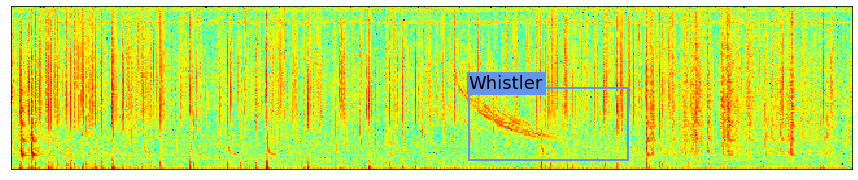

In [43]:
# linewidth = 2
# font_title = 32
# font_legend = 20
# font_label = 24
# font_ticks = 18
# font = [font_title, font_legend, font_label, font_ticks, linewidth] # [None]*5

# dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
# site = 'marion'
# database = Database(dataset_loc, database_loc, site)
# t, t_params = [None], [None]
# file = database.get_random_sample()
# file = '2013-05-09UT18:30:25.86469656.marion.vr2'
# print(file)
# data, labels = database.load_yolo_file(file,t, t_params)
# database.show_yolo_labelled_img(data,labels, rgb=False, noise=False, cmap='jet', font=font)

In [2]:
# from sklearn import model_selection,preprocessing
# dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
# site = 'marion'
# my_database = Database(dataset_loc, database_loc, site)
# transforms = ['zscore']
# transforms_params = [[None]]
# my_database.create_cuts_db_mp(transforms=transforms, transforms_params=transforms_params,
#                               cut_params=[0.7,0.3,7.5,2.5,0.3], verbose=True, noise=True, train=True, test=True)
# # data, targets = my_database.load_cuts_db_mp(transforms=['zscore'], transforms_params=[[None]], verbose=True, noise=True, test=False)
# # X_mean = my_database.whistler_mean(transforms=['zscore'], transforms_params=[[None]], cut_time=0.7, cut_time_split=0.3, cut_freq=7.5,cut_freq_min=2.5, time_err=0.3)
# # plt.figure(figsize=(4,2)); plt.pcolormesh(X_mean, cmap='jet');plt.title('Mean');plt.show()

# # X, Y, _X, _Y = my_database.augmented_events(transforms=['zscore'], transforms_params=[[None]], cut_time=0.7, cut_time_split=0.3, cut_freq=7.5,cut_freq_min=2.5, time_err=0.3,noise=True, test=False)
# # __X, __Y = my_database.augmented_data(X,Y,_X,_Y)

100%|██████████| 725/725 [00:30<00:00, 23.46it/s]
